In [ ]:
import astropy.units as u
from astropy.coordinates import SkyCoord,ICRS,Galactic,GalacticLSR,Distance
import pandas as pd
from astropy.table import Table, join,vstack
import numpy as np
import math
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from scipy import ndimage, interpolate
from scipy.ndimage import gaussian_filter1d
from scipy.stats import norm
from scipy.signal import find_peaks
import healpy as hp
from tqdm import tqdm

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Query dustmaps and Produce Density Files

- Dust map from Edenhofer 2024. 
- Query both arithmetic mean map and 12 samples. \
- Calculation: 

data: unit [E] \
Convert to A_G using the extinction table: $A_{G} = data*2.040684938430786 [mag]$ \
Convert to column density: use relation $\frac{A_{G}}{N_{H}} = 4*10^{-22} cm^{2}*mag $ \
$N_{H} = \frac{A_{G}}{4* 10^{-22} cm^{2}* mag} = \frac{data*2.040684938430786}{4*10^{-22}} [cm^{-2}]$ \

Meaning that the column density(unit: $cm^{-2}$) is in fact a volume of $V_{0}=1cm^{2}*1pc = 3.0857*10^{18} cm^3 $ \
volume density: $n_{H}=\frac{N_H}{V_{0}} = \frac{data*2.040684938430786}{4*10^{-22}*3.0857*10^{18}} [cm^{-3}] = data *1653.34 [cm^{-3}]$

In [ ]:
import dustmaps.edenhofer2023
from dustmaps.edenhofer2023 import Edenhofer2023Query
dustmaps.edenhofer2023.fetch(fetch_samples=True)
edenhofer = Edenhofer2023Query(load_samples=True)

In [ ]:
NSIDE = 128 #256
ip= np.arange(0,hp.nside2npix(NSIDE)) 
theta, phi = hp.pix2ang(nside=NSIDE, ipix=ip)
# center of Gum Nebula:
x_G = -67 #pc
y_G = -334 #pc
z_G = -65 #pc
r_world = 350 #pc;
x_ph = x_G + r_world* np.sin(theta)* np.cos(phi)
y_ph = y_G + r_world* np.sin(theta)*np.sin(phi) 
z_ph = z_G + r_world* np.cos(theta)
#create a grid of sample points
n_grid = int(r_world)+1   #sampling stepsize=1pc
loc = np.zeros((len(x_ph), 3, n_grid))  #value [pc]
for w in tqdm(range(len(x_ph))):
    loc[w, 0, :] = np.linspace(x_G, x_ph[w], n_grid)
    loc[w, 1, :] = np.linspace(y_G, y_ph[w], n_grid)
    loc[w, 2, :] = np.linspace(z_G, z_ph[w], n_grid)

100%|██████████| 196608/196608 [00:05<00:00, 35690.78it/s]


In [552]:
#store all the sample data in the density_grid -- 12 samples
nsample= edenhofer.n_samples
density_grid = np.zeros((len(x_ph), nsample, n_grid))
for i in tqdm(range(len(loc))):
    x = loc[i, 0, :]
    y = loc[i, 1, :]
    z = loc[i, 2, :]
    coord = SkyCoord(u = x*u.pc, v = y*u.pc, w = z*u.pc, representation_type='cartesian', frame='galactic').galacticlsr
    density_grid[i, :, :] = 2*826.67* edenhofer(coord, mode='samples').T    #now volume density in the unit of (1pc*1cm*1cm)

100%|██████████████████████████████████| 196608/196608 [06:37<00:00, 495.22it/s]


In [537]:
# np.savez('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/uncertainty_sample/npix256/density_grid256.npz', density_grid)
# np.load()
# density_line1 = density_grid[:, 2,:]
# np.savez('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/uncertainty_sample/npix256/density_grid_map2.npz', density_line1)

### For posterior mean map, find the inner and outer boundaries 

- The mean map is the arithmetic mean of the 12 different realizations

In [6]:
out_dir = '/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/uncertainty_sample/npix128/'
mean_map_file = np.load('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/uncertainty_sample/npix128/density_grid128_mean.npz')
arr = mean_map_file.files[0]
density_mean_map = mean_map_file[arr]

In [ ]:
density_line = density_mean_map

sigma = 10 #smoothing gaussian kernel 
boundary = pd.DataFrame(columns=['x[pc]', 'y[pc]', 'z[pc]', 'l[deg]', 'b[deg]', 'd[pc]','index', 'r_raw'])
boundary_out = pd.DataFrame(columns=['x[pc]', 'y[pc]', 'z[pc]', 'l[deg]', 'b[deg]', 'd[pc]','index', 'r_raw'])
# print("Analyzing dust map", map_index, ' with sigma', sigma) 
for p in tqdm(range(density_line.shape[0])):

    dist = np.linspace(0, r_world, n_grid)
    gau_1D_dens = gaussian_filter1d(density_line[p], sigma)
    d1 = np.gradient(gau_1D_dens, dist)
    d2 = np.gradient(d1,dist)
    pos_inflection = np.where(d1>0)

    zero_inds = np.where(np.diff(np.sign(d2))!= 0)[0]
    print(zero_inds)
    possible_inner_inds = np.concatenate((zero_inds,zero_inds+1))
    inner_indices = np.intersect1d(possible_inner_inds,pos_inflection)
    print(inner_indices)
    try:
        inner_i = inner_indices[0]
        inner_dist= dist[inner_i]
    except:
        try:
            inner_i = zero_inds[0]
            inner_dist= dist[inner_i]
        except Exception:
            inner_i = np.nan
            inner_dist = np.nan
            print("No inflection points found for index", p)

    try:

        inf_z, inf_y, inf_x = loc[p, 2, inner_i], loc[p, 1, inner_i], loc[p, 0, inner_i]  #coordinate in the xyz frame
        galactic_lbd = SkyCoord(x = inf_x*u.pc, y = inf_y*u.pc, z = inf_z*u.pc, representation_type='cartesian').spherical
        boundary.loc[len(boundary)] = [inf_x, inf_y, inf_z, galactic_lbd.lon.value, galactic_lbd.lat.value, 
                                    galactic_lbd.distance.value, p, inner_dist]

    except Exception:
        boundary.loc[len(boundary)] = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, p, np.nan]

    try:
        outer_i = zero_inds[np.where(zero_inds==inner_i)[0][0]+1]
        outer_dist = dist[outer_i]

    except:
        outer_i = np.nan
        outer_dist = np.nan
        print("No outer boundary found for index", p)

    try:
        inf_z_out, inf_y_out, inf_x_out = loc[p, 2, outer_i],loc[p, 1, outer_i], loc[p, 0, outer_i]
        galactic_lbd_out = SkyCoord(x = inf_x_out*u.pc, y = inf_y_out*u.pc, z = inf_z_out*u.pc, representation_type='cartesian').spherical
        boundary_out.loc[len(boundary_out)] = [inf_x_out, inf_y_out, inf_z_out, galactic_lbd_out.lon.value, galactic_lbd_out.lat.value, 
                                                galactic_lbd_out.distance.value, p, outer_dist]
    except Exception:
        boundary_out.loc[len(boundary_out)] = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, p, np.nan]

# boundary_file = out_dir+f'boundary_map{map_index}_sigma{sigma}.csv'
# boundary.to_csv(boundary_file, index=False)
# 
# boundary_out_file = out_dir+f'boundaryout_map{map_index}_sigma{sigma}.csv'
# boundary_out.to_csv(boundary_out_file, index=False)

[ 15 143 193 279 285 319 332]
[143 144]


### Example of the derived density profiles and boundaries

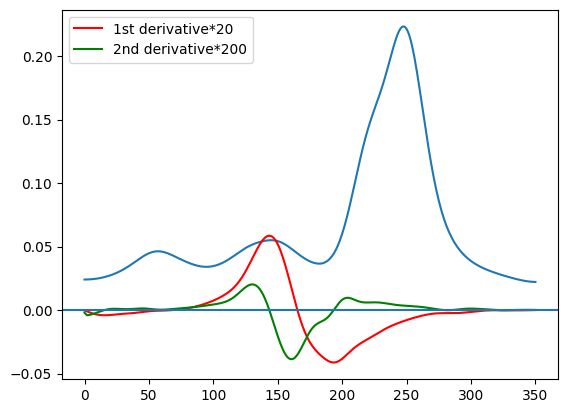

In [55]:
p= 17907
plt.plot(np.arange(0, 351), gaussian_filter1d(density_line[p,:], 10) )
plt.plot(np.arange(0, 351), d1*20, 'r', label='1st derivative*20')
plt.plot(np.arange(0, 351), d2*200, 'g', label='2nd derivative*200')
# plt.scatter(boundary.iloc[p]['r_raw'], 0)
# plt.scatter(boundary_out.iloc[p]['r_raw'], 0)
plt.axhline(0)
plt.legend()

### For 12 different posterior map realizations, find the inner and outer boundaries 

In [ ]:
out_dir = '/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/uncertainty_sample/npix128/'

for map_index in range(nsample): 
    density_line = pd.DataFrame(density_grid[:, map_index,:].T)

    for sigma in [6, 7, 8, 9, 10, 11, 12, 13, 14]:
        boundary = pd.DataFrame(columns=['x[pc]', 'y[pc]', 'z[pc]', 'l[deg]', 'b[deg]', 'd[pc]','index', 'r_raw'])
        boundary_out = pd.DataFrame(columns=['x[pc]', 'y[pc]', 'z[pc]', 'l[deg]', 'b[deg]', 'd[pc]','index', 'r_raw'])
        print("Analyzing dust map", map_index, ' with sigma', sigma) 
        for p in tqdm(range(density_line.shape[1])):
            dist = np.linspace(0, r_world, n_grid)
            gau_1D_dens = gaussian_filter1d(density_line[p], sigma)
            d1 = np.gradient(gau_1D_dens, dist)
            d2 = np.gradient(d1,dist)
            pos_inflection = np.where(d1>0)
            zero_inds = np.where(np.diff(np.sign(d2))!= 0)[0]
            possible_inner_inds = np.concatenate((zero_inds,zero_inds+1))
            inner_indices = np.intersect1d(possible_inner_inds,pos_inflection)

            try:
                inner_i = inner_indices[0]
                inner_dist= dist[inner_i]
            except:
                try:
                    inner_i = zero_inds[0]
                    inner_dist= dist[inner_i]

                except Exception:
                    inner_i = np.nan
                    inner_dist = np.nan
                    print("No inflection points found for index", p)

            try:

                inf_z, inf_y, inf_x = loc[p, 2, inner_i], loc[p, 1, inner_i], loc[p, 0, inner_i]  #coordinate in the xyz frame
                galactic_lbd = SkyCoord(x = inf_x*u.pc, y = inf_y*u.pc, z = inf_z*u.pc, representation_type='cartesian').spherical
                boundary.loc[len(boundary)] = [inf_x, inf_y, inf_z, galactic_lbd.lon.value, galactic_lbd.lat.value, 
                                           galactic_lbd.distance.value, p, inner_dist]

            except Exception:
                boundary.loc[len(boundary)] = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, p, np.nan]

            try:
                outer_i = zero_inds[np.where(zero_inds==inner_i)[0][0]+1]
                outer_dist = dist[outer_i]

            except:
                outer_i = np.nan
                outer_dist = np.nan
                print("No outer boundary found for index", p)

            try:
                inf_z_out, inf_y_out, inf_x_out = loc[p, 2, outer_i],loc[p, 1, outer_i], loc[p, 0, outer_i]
                galactic_lbd_out = SkyCoord(x = inf_x_out*u.pc, y = inf_y_out*u.pc, z = inf_z_out*u.pc, representation_type='cartesian').spherical
                boundary_out.loc[len(boundary_out)] = [inf_x_out, inf_y_out, inf_z_out, galactic_lbd_out.lon.value, galactic_lbd_out.lat.value, 
                                                       galactic_lbd_out.distance.value, p, outer_dist]
            except Exception:
                boundary_out.loc[len(boundary_out)] = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, p, np.nan]

        boundary_file = out_dir+f'boundary_map{map_index}_sigma{sigma}.csv'
        boundary.to_csv(boundary_file, index=False)

        boundary_out_file = out_dir+f'boundaryout_map{map_index}_sigma{sigma}.csv'
        boundary_out.to_csv(boundary_out_file, index=False)

Analyzing dust map 0  with sigma 12


  6%|█▉                                 | 10990/196608 [00:18<05:23, 574.59it/s]

No outer boundary found for index 10910


  6%|██▏                                | 12208/196608 [00:20<05:35, 549.58it/s]

No outer boundary found for index 12128


  8%|██▋                                | 14748/196608 [00:25<05:25, 559.03it/s]

No outer boundary found for index 14692


100%|██████████████████████████████████| 196608/196608 [16:03<00:00, 203.96it/s]


Analyzing dust map 0  with sigma 10.5


  0%|                                     | 279/196608 [00:02<25:06, 130.28it/s]

No outer boundary found for index 256


  0%|                                     | 442/196608 [00:03<25:46, 126.85it/s]

No outer boundary found for index 423


  0%|                                     | 579/196608 [00:04<25:30, 128.12it/s]

No outer boundary found for index 557


  3%|▉                                   | 5371/196608 [00:43<28:00, 113.81it/s]

No outer boundary found for index 5359
No outer boundary found for index 5374


  4%|█▎                                  | 7202/196608 [00:59<25:22, 124.43it/s]

No outer boundary found for index 7178


  4%|█▎                                  | 7420/196608 [01:00<22:27, 140.45it/s]

No outer boundary found for index 7392


  4%|█▎                                  | 7448/196608 [01:01<25:33, 123.36it/s]

No outer boundary found for index 7427


  4%|█▌                                  | 8668/196608 [01:11<27:01, 115.87it/s]

No outer boundary found for index 8655


  5%|█▊                                  | 9777/196608 [01:21<27:39, 112.60it/s]

No outer boundary found for index 9759


  5%|█▊                                 | 10028/196608 [01:23<26:44, 116.31it/s]

No outer boundary found for index 10008


  7%|██▍                                | 14035/196608 [01:59<27:44, 109.71it/s]

No outer boundary found for index 14019


 12%|████▏                              | 23615/196608 [03:26<26:16, 109.75it/s]

No outer boundary found for index 23594


100%|███████████████████████████████████| 196608/196608 [39:47<00:00, 82.36it/s]


Analyzing dust map 0  with sigma 9


  0%|                                      | 299/196608 [00:04<53:56, 60.65it/s]

No outer boundary found for index 289


  0%|                                      | 341/196608 [00:05<53:26, 61.21it/s]

No outer boundary found for index 333


  0%|▏                                     | 852/196608 [00:13<50:12, 64.99it/s]

No outer boundary found for index 846


  1%|▏                                    | 1027/196608 [00:16<51:03, 63.85it/s]

No outer boundary found for index 1017


  2%|▊                                    | 4038/196608 [01:04<51:53, 61.85it/s]

No outer boundary found for index 4027


  2%|▊                                    | 4409/196608 [01:10<49:09, 65.16it/s]

No outer boundary found for index 4395


  2%|▉                                    | 4787/196608 [01:16<54:45, 58.39it/s]

No outer boundary found for index 4779


  3%|▉                                    | 5179/196608 [01:22<51:02, 62.50it/s]

No outer boundary found for index 5167


  3%|█                                    | 5599/196608 [01:29<49:39, 64.11it/s]

No outer boundary found for index 5585


  4%|█▌                                   | 8427/196608 [02:15<53:16, 58.87it/s]

No outer boundary found for index 8416


  4%|█▋                                   | 8686/196608 [02:19<49:37, 63.12it/s]

No outer boundary found for index 8675


  6%|██▏                                 | 12095/196608 [03:16<51:08, 60.14it/s]

No outer boundary found for index 12084
No outer boundary found for index 12085


 10%|███▋                                | 19881/196608 [05:30<54:58, 53.57it/s]

No outer boundary found for index 19873


 10%|███▋                                | 19902/196608 [05:31<49:32, 59.45it/s]

No outer boundary found for index 19894


100%|█████████████████████████████████| 196608/196608 [1:06:11<00:00, 49.50it/s]


Analyzing dust map 0  with sigma 7.5


  0%|                                    | 129/196608 [00:03<1:19:05, 41.40it/s]

No outer boundary found for index 120


  0%|                                    | 279/196608 [00:06<1:23:54, 39.00it/s]

No outer boundary found for index 275


  0%|                                    | 629/196608 [00:15<1:20:37, 40.51it/s]

No outer boundary found for index 623


  1%|▏                                  | 1349/196608 [00:32<1:14:56, 43.43it/s]

No outer boundary found for index 1341


  1%|▎                                  | 1454/196608 [00:34<1:19:23, 40.97it/s]

No outer boundary found for index 1448


  1%|▎                                  | 1564/196608 [00:37<1:20:40, 40.30it/s]

No outer boundary found for index 1558


  1%|▎                                  | 1679/196608 [00:40<1:14:54, 43.37it/s]

No outer boundary found for index 1672


  1%|▎                                  | 1789/196608 [00:42<1:14:51, 43.38it/s]

No outer boundary found for index 1784


  1%|▎                                  | 1914/196608 [00:45<1:15:42, 42.86it/s]

No outer boundary found for index 1905


  4%|█▎                                 | 7663/196608 [03:05<1:17:57, 40.39it/s]

No outer boundary found for index 7655


  4%|█▍                                 | 7913/196608 [03:11<1:13:55, 42.55it/s]

No outer boundary found for index 7905


  4%|█▍                                 | 8163/196608 [03:17<1:15:09, 41.79it/s]

No outer boundary found for index 8154


  7%|██▎                               | 13688/196608 [05:33<1:19:12, 38.49it/s]

No outer boundary found for index 13681


100%|█████████████████████████████████| 196608/196608 [1:30:41<00:00, 36.13it/s]


Analyzing dust map 1  with sigma 12


  3%|█▏                                  | 6204/196608 [00:09<04:37, 687.06it/s]

No outer boundary found for index 6111


  4%|█▍                                  | 7990/196608 [00:11<05:05, 616.57it/s]

No outer boundary found for index 7885


 20%|███████                            | 39577/196608 [01:17<06:52, 381.14it/s]

No outer boundary found for index 39518


100%|██████████████████████████████████| 196608/196608 [15:21<00:00, 213.32it/s]


Analyzing dust map 1  with sigma 10.5


  4%|█▌                                  | 8676/196608 [01:12<26:47, 116.89it/s]

No outer boundary found for index 8653


 12%|████                               | 23024/196608 [03:23<26:08, 110.64it/s]

No outer boundary found for index 23001


100%|███████████████████████████████████| 196608/196608 [39:38<00:00, 82.68it/s]


Analyzing dust map 1  with sigma 9


  2%|▋                                    | 3691/196608 [00:57<54:23, 59.12it/s]

No outer boundary found for index 3680


  2%|▋                                    | 3740/196608 [00:58<51:17, 62.67it/s]

No outer boundary found for index 3733


  2%|▊                                    | 4412/196608 [01:09<49:24, 64.82it/s]

No outer boundary found for index 4398


  3%|█▏                                   | 6022/196608 [01:35<49:11, 64.58it/s]

No outer boundary found for index 6017


  4%|█▍                                   | 7506/196608 [01:58<49:57, 63.09it/s]

No outer boundary found for index 7498


  6%|██                                  | 11352/196608 [03:01<50:31, 61.10it/s]

No outer boundary found for index 11339


  8%|██▉                                 | 16323/196608 [04:25<49:01, 61.29it/s]

No outer boundary found for index 16316


  9%|███▏                                | 17427/196608 [04:44<51:24, 58.09it/s]

No outer boundary found for index 17417


 47%|█████████████████                   | 93291/196608 [28:08<34:17, 50.21it/s]

No outer boundary found for index 93285


 48%|█████████████████▏                  | 93801/196608 [28:19<32:33, 52.62it/s]

No outer boundary found for index 93794


100%|█████████████████████████████████| 196608/196608 [1:06:06<00:00, 49.57it/s]


Analyzing dust map 1  with sigma 7.5


  1%|▍                                  | 2633/196608 [01:03<1:17:49, 41.54it/s]

No outer boundary found for index 2625


  3%|█                                  | 5672/196608 [02:17<1:21:05, 39.24it/s]

No outer boundary found for index 5665


  4%|█▎                                 | 7547/196608 [03:03<1:15:00, 42.01it/s]

No outer boundary found for index 7538


  5%|█▋                                 | 9457/196608 [03:50<1:12:54, 42.78it/s]

No outer boundary found for index 9452


  5%|█▊                                | 10177/196608 [04:07<1:15:05, 41.38it/s]

No outer boundary found for index 10172
No outer boundary found for index 10173


  5%|█▊                                | 10427/196608 [04:13<1:16:04, 40.79it/s]

No outer boundary found for index 10421


  6%|█▉                                | 11356/196608 [04:36<1:15:28, 40.91it/s]

No outer boundary found for index 11351


  6%|██▏                               | 12441/196608 [05:02<1:11:34, 42.89it/s]

No outer boundary found for index 12434


  7%|██▎                               | 13556/196608 [05:30<1:12:55, 41.83it/s]

No outer boundary found for index 13548


  7%|██▍                               | 13741/196608 [05:34<1:11:29, 42.63it/s]

No outer boundary found for index 13735


  9%|███▏                              | 18546/196608 [07:33<1:14:46, 39.69it/s]

No outer boundary found for index 18538


 40%|██████████████▎                     | 78449/196608 [33:21<51:11, 38.48it/s]

No outer boundary found for index 78442


 40%|██████████████▌                     | 79479/196608 [33:49<53:41, 36.36it/s]

No outer boundary found for index 79475


 43%|███████████████▌                    | 85092/196608 [36:21<50:14, 36.99it/s]

No outer boundary found for index 85086


 45%|████████████████▎                   | 89195/196608 [38:13<47:09, 37.96it/s]

No outer boundary found for index 89191


100%|█████████████████████████████████| 196608/196608 [1:30:36<00:00, 36.16it/s]


Analyzing dust map 2  with sigma 12


  1%|▎                                   | 1748/196608 [00:02<04:33, 712.50it/s]

No outer boundary found for index 1661
No outer boundary found for index 1708


  1%|▎                                   | 2039/196608 [00:02<04:35, 707.32it/s]

No outer boundary found for index 1951


  1%|▍                                   | 2328/196608 [00:03<04:39, 694.71it/s]

No outer boundary found for index 2209


  5%|█▉                                 | 10570/196608 [00:16<05:08, 602.96it/s]

No outer boundary found for index 10459


  6%|██                                 | 11915/196608 [00:18<05:17, 581.00it/s]

No outer boundary found for index 11838


 24%|████████▌                          | 47774/196608 [01:40<06:51, 361.52it/s]

No outer boundary found for index 47700


100%|██████████████████████████████████| 196608/196608 [15:22<00:00, 213.21it/s]


Analyzing dust map 2  with sigma 10.5


  2%|▋                                   | 3506/196608 [00:28<26:40, 120.68it/s]

No outer boundary found for index 3492
No outer boundary found for index 3501


  2%|▋                                   | 4046/196608 [00:32<20:53, 153.57it/s]

No outer boundary found for index 4016


  2%|▊                                   | 4268/196608 [00:33<21:39, 148.05it/s]

No outer boundary found for index 4248


  2%|▊                                   | 4406/196608 [00:34<24:35, 130.26it/s]

No outer boundary found for index 4380


  5%|█▊                                  | 9591/196608 [01:20<26:50, 116.11it/s]

No outer boundary found for index 9579


  5%|█▉                                 | 10653/196608 [01:29<29:08, 106.35it/s]

No outer boundary found for index 10635


  6%|██▏                                | 12183/196608 [01:43<29:07, 105.57it/s]

No outer boundary found for index 12171


  7%|██▎                                | 13109/196608 [01:52<29:29, 103.70it/s]

No outer boundary found for index 13097


  8%|██▋                                | 14918/196608 [02:08<24:12, 125.12it/s]

No outer boundary found for index 14898


  8%|██▉                                | 16179/196608 [02:19<29:36, 101.59it/s]

No outer boundary found for index 16162


  9%|███▏                               | 17732/196608 [02:33<26:22, 113.05it/s]

No outer boundary found for index 17709


 20%|███████                             | 38513/196608 [05:49<27:36, 95.42it/s]

No outer boundary found for index 38496


 24%|████████▌                           | 46663/196608 [07:11<27:02, 92.39it/s]

No outer boundary found for index 46653


 34%|████████████▎                       | 67197/196608 [10:44<22:51, 94.35it/s]

No outer boundary found for index 67185


100%|███████████████████████████████████| 196608/196608 [39:30<00:00, 82.93it/s]


Analyzing dust map 2  with sigma 9


  2%|▊                                    | 4598/196608 [01:12<50:08, 63.83it/s]

No outer boundary found for index 4585


  2%|▊                                    | 4633/196608 [01:12<50:29, 63.37it/s]

No outer boundary found for index 4624


  3%|█                                    | 5810/196608 [01:31<48:49, 65.14it/s]

No outer boundary found for index 5801


  3%|█▎                                   | 6705/196608 [01:46<51:03, 61.98it/s]

No outer boundary found for index 6694


  4%|█▎                                   | 6992/196608 [01:50<50:49, 62.17it/s]

No outer boundary found for index 6985


  5%|█▊                                   | 9511/196608 [02:31<52:52, 58.98it/s]

No outer boundary found for index 9503


  6%|██▏                                 | 11716/196608 [03:07<51:49, 59.46it/s]

No outer boundary found for index 11707


  6%|██▏                                 | 11945/196608 [03:11<51:17, 60.00it/s]

No outer boundary found for index 11934


  6%|██▏                                 | 12147/196608 [03:15<51:01, 60.25it/s]

No outer boundary found for index 12138


  7%|██▌                                 | 13762/196608 [03:42<54:57, 55.45it/s]

No outer boundary found for index 13752


  8%|██▊                                 | 15589/196608 [04:14<54:31, 55.32it/s]

No outer boundary found for index 15581


  9%|███▏                                | 17700/196608 [04:50<51:28, 57.93it/s]

No outer boundary found for index 17692


  9%|███▎                                | 18431/196608 [05:02<49:48, 59.63it/s]

No outer boundary found for index 18423


  9%|███▍                                | 18528/196608 [05:04<49:16, 60.24it/s]

No outer boundary found for index 18516


 10%|███▌                                | 19254/196608 [05:16<49:48, 59.35it/s]

No outer boundary found for index 19247


 10%|███▋                                | 20415/196608 [05:36<50:07, 58.58it/s]

No outer boundary found for index 20402


 11%|███▉                                | 21739/196608 [05:59<50:20, 57.89it/s]

No outer boundary found for index 21728


 12%|████▏                               | 22986/196608 [06:21<48:19, 59.89it/s]

No outer boundary found for index 22976


 13%|████▊                               | 26096/196608 [07:15<51:44, 54.92it/s]

No outer boundary found for index 26089
No outer boundary found for index 26098


 14%|█████                               | 27497/196608 [07:38<49:22, 57.09it/s]

No outer boundary found for index 27485


 22%|███████▊                            | 42625/196608 [12:08<45:08, 56.84it/s]

No outer boundary found for index 42614


 23%|████████▏                           | 44647/196608 [12:45<47:11, 53.67it/s]

No outer boundary found for index 44637


 24%|████████▋                           | 47225/196608 [13:32<44:10, 56.36it/s]

No outer boundary found for index 47214


 27%|█████████▋                          | 52864/196608 [15:15<42:48, 55.95it/s]

No outer boundary found for index 52859


 27%|█████████▊                          | 53860/196608 [15:34<46:51, 50.77it/s]

No outer boundary found for index 53851


100%|█████████████████████████████████| 196608/196608 [1:06:14<00:00, 49.47it/s]


Analyzing dust map 2  with sigma 7.5


  3%|▉                                  | 5223/196608 [02:06<1:23:05, 38.39it/s]

No outer boundary found for index 5217


  3%|█                                  | 6093/196608 [02:27<1:15:39, 41.97it/s]

No outer boundary found for index 6087


  4%|█▎                                 | 7428/196608 [03:00<1:16:14, 41.35it/s]

No outer boundary found for index 7422


  4%|█▍                                 | 7953/196608 [03:13<1:14:20, 42.30it/s]

No outer boundary found for index 7947


  4%|█▌                                 | 8488/196608 [03:26<1:22:58, 37.78it/s]

No outer boundary found for index 8483


  4%|█▌                                 | 8748/196608 [03:33<1:18:40, 39.79it/s]

No outer boundary found for index 8743


  5%|█▋                                 | 9268/196608 [03:45<1:20:34, 38.75it/s]

No outer boundary found for index 9261


  5%|█▊                                | 10403/196608 [04:13<1:16:02, 40.82it/s]

No outer boundary found for index 10394
No outer boundary found for index 10400


  6%|█▉                                | 11318/196608 [04:36<1:15:26, 40.94it/s]

No outer boundary found for index 11313


  6%|██                                | 11578/196608 [04:42<1:13:49, 41.77it/s]

No outer boundary found for index 11570


  6%|██                                | 11618/196608 [04:43<1:18:36, 39.22it/s]

No outer boundary found for index 11612


  6%|██                                | 12183/196608 [04:57<1:13:51, 41.62it/s]

No outer boundary found for index 12174


  7%|██▎                               | 13088/196608 [05:20<1:19:52, 38.29it/s]

No outer boundary found for index 13083


  7%|██▎                               | 13183/196608 [05:22<1:17:13, 39.59it/s]

No outer boundary found for index 13178


  7%|██▍                               | 14133/196608 [05:46<1:16:18, 39.85it/s]

No outer boundary found for index 14126


  9%|██▉                               | 17313/196608 [07:04<1:13:45, 40.51it/s]

No outer boundary found for index 17306


  9%|███                               | 18038/196608 [07:22<1:15:39, 39.34it/s]

No outer boundary found for index 18033


  9%|███▏                              | 18098/196608 [07:24<1:18:22, 37.96it/s]

No outer boundary found for index 18091


  9%|███▏                              | 18477/196608 [07:33<1:10:34, 42.07it/s]

No outer boundary found for index 18474


 10%|███▍                              | 19942/196608 [08:10<1:10:22, 41.84it/s]

No outer boundary found for index 19934


 12%|████                              | 23807/196608 [09:46<1:16:35, 37.60it/s]

No outer boundary found for index 23802


 13%|████▎                             | 25134/196608 [10:19<1:10:48, 40.36it/s]

No outer boundary found for index 25127


 14%|████▉                             | 28406/196608 [11:41<1:08:00, 41.22it/s]

No outer boundary found for index 28403


 15%|████▉                             | 28895/196608 [11:54<1:08:40, 40.70it/s]

No outer boundary found for index 28892


 19%|██████▍                           | 37453/196608 [15:31<1:06:35, 39.83it/s]

No outer boundary found for index 37446


 19%|██████▌                           | 38001/196608 [15:45<1:07:14, 39.31it/s]

No outer boundary found for index 37996


 20%|██████▋                           | 38964/196608 [16:10<1:04:29, 40.74it/s]

No outer boundary found for index 38959


 21%|███████                           | 41048/196608 [17:04<1:05:10, 39.78it/s]

No outer boundary found for index 41043


 21%|███████                           | 41077/196608 [17:04<1:09:26, 37.33it/s]

No outer boundary found for index 41072


 27%|█████████▏                        | 52830/196608 [22:13<1:00:05, 39.88it/s]

No outer boundary found for index 52822


 34%|████████████                        | 66151/196608 [28:07<55:27, 39.21it/s]

No outer boundary found for index 66145


 55%|███████████████████▎               | 108651/196608 [47:33<43:08, 33.98it/s]

No outer boundary found for index 108646


100%|█████████████████████████████████| 196608/196608 [1:32:06<00:00, 35.57it/s]


Analyzing dust map 3  with sigma 12


  2%|▋                                   | 3716/196608 [00:05<04:44, 678.46it/s]

No outer boundary found for index 3635


  2%|▊                                   | 4354/196608 [00:06<04:58, 645.12it/s]

No outer boundary found for index 4349


  2%|▉                                   | 4813/196608 [00:07<05:01, 635.43it/s]

No outer boundary found for index 4730


  3%|█                                   | 5663/196608 [00:08<05:17, 602.30it/s]

No outer boundary found for index 5594


  3%|█                                   | 6079/196608 [00:09<05:05, 624.56it/s]

No outer boundary found for index 5974


  4%|█▌                                  | 8816/196608 [00:13<05:10, 605.29it/s]

No outer boundary found for index 8704


  5%|█▊                                  | 9882/196608 [00:15<05:14, 592.79it/s]

No outer boundary found for index 9782


100%|██████████████████████████████████| 196608/196608 [15:37<00:00, 209.74it/s]


Analyzing dust map 3  with sigma 10.5


  0%|▏                                    | 861/196608 [00:06<22:09, 147.27it/s]

No outer boundary found for index 841


  1%|▍                                   | 2302/196608 [00:18<26:44, 121.11it/s]

No outer boundary found for index 2284


  2%|▌                                   | 3374/196608 [00:27<26:30, 121.48it/s]

No outer boundary found for index 3348


  2%|▋                                   | 3836/196608 [00:31<25:54, 124.05it/s]

No outer boundary found for index 3817


  3%|█                                   | 5508/196608 [00:45<31:23, 101.47it/s]

No outer boundary found for index 5489


  3%|█▏                                  | 6521/196608 [00:55<28:04, 112.84it/s]

No outer boundary found for index 6504


  6%|█▉                                 | 11166/196608 [01:38<28:45, 107.45it/s]

No outer boundary found for index 11157


  6%|██                                 | 11509/196608 [01:41<30:48, 100.16it/s]

No outer boundary found for index 11493


  6%|██▏                                | 12181/196608 [01:47<27:53, 110.19it/s]

No outer boundary found for index 12159


 10%|███▍                               | 19185/196608 [02:54<23:18, 126.87it/s]

No outer boundary found for index 19168


100%|███████████████████████████████████| 196608/196608 [39:09<00:00, 83.67it/s]


Analyzing dust map 3  with sigma 9


  1%|▎                                    | 1444/196608 [00:22<52:17, 62.20it/s]

No outer boundary found for index 1431


  1%|▎                                    | 1549/196608 [00:24<53:29, 60.78it/s]

No outer boundary found for index 1540


  1%|▍                                    | 2278/196608 [00:35<49:38, 65.23it/s]

No outer boundary found for index 2269


  1%|▍                                    | 2460/196608 [00:38<53:15, 60.75it/s]

No outer boundary found for index 2455


  1%|▍                                    | 2595/196608 [00:40<49:22, 65.49it/s]

No outer boundary found for index 2587


  1%|▌                                    | 2880/196608 [00:45<46:40, 69.16it/s]

No outer boundary found for index 2868


  2%|▋                                    | 3491/196608 [00:54<46:37, 69.03it/s]

No outer boundary found for index 3483


  2%|▋                                    | 3530/196608 [00:55<46:32, 69.14it/s]

No outer boundary found for index 3518
No outer boundary found for index 3522


  2%|▊                                    | 4239/196608 [01:06<48:41, 65.84it/s]

No outer boundary found for index 4231


  2%|▊                                    | 4402/196608 [01:08<52:39, 60.83it/s]

No outer boundary found for index 4394
No outer boundary found for index 4405


  2%|▊                                    | 4423/196608 [01:09<48:40, 65.80it/s]

No outer boundary found for index 4417


  3%|▉                                    | 5172/196608 [01:21<47:59, 66.48it/s]

No outer boundary found for index 5167


  3%|▉                                    | 5274/196608 [01:22<47:50, 66.66it/s]

No outer boundary found for index 5266


  3%|█                                    | 5368/196608 [01:24<50:05, 63.63it/s]

No outer boundary found for index 5360


  3%|█                                    | 5579/196608 [01:27<48:30, 65.63it/s]

No outer boundary found for index 5571


  3%|█                                    | 5691/196608 [01:29<47:15, 67.32it/s]

No outer boundary found for index 5679


  3%|█▏                                   | 6497/196608 [01:41<51:27, 61.57it/s]

No outer boundary found for index 6490


  4%|█▍                                   | 7964/196608 [02:05<53:59, 58.23it/s]

No outer boundary found for index 7958


  4%|█▋                                   | 8690/196608 [02:16<47:56, 65.33it/s]

No outer boundary found for index 8681


  5%|█▊                                   | 9314/196608 [02:26<49:46, 62.71it/s]

No outer boundary found for index 9303


  5%|█▊                                   | 9758/196608 [02:33<49:05, 63.44it/s]

No outer boundary found for index 9745


  5%|█▉                                  | 10343/196608 [02:42<51:45, 59.98it/s]

No outer boundary found for index 10333


  9%|███▎                                | 18402/196608 [04:58<49:43, 59.74it/s]

No outer boundary found for index 18396


 21%|███████▌                            | 41087/196608 [11:35<46:47, 55.40it/s]

No outer boundary found for index 41079


100%|█████████████████████████████████| 196608/196608 [1:06:46<00:00, 49.07it/s]


Analyzing dust map 3  with sigma 7.5


  0%|                                    | 238/196608 [00:05<1:15:51, 43.15it/s]

No outer boundary found for index 229


  0%|                                    | 343/196608 [00:08<1:15:45, 43.17it/s]

No outer boundary found for index 336


  0%|                                    | 563/196608 [00:13<1:19:21, 41.17it/s]

No outer boundary found for index 557


  0%|                                    | 653/196608 [00:15<1:15:51, 43.05it/s]

No outer boundary found for index 648


  0%|▏                                   | 878/196608 [00:20<1:15:43, 43.08it/s]

No outer boundary found for index 872


  1%|▎                                  | 1548/196608 [00:36<1:17:13, 42.10it/s]

No outer boundary found for index 1543


  1%|▎                                  | 1673/196608 [00:39<1:15:10, 43.22it/s]

No outer boundary found for index 1665


  1%|▎                                  | 1788/196608 [00:42<1:16:29, 42.45it/s]

No outer boundary found for index 1782


  1%|▎                                  | 1933/196608 [00:45<1:15:46, 42.82it/s]

No outer boundary found for index 1925


  1%|▍                                  | 2573/196608 [01:00<1:16:41, 42.17it/s]

No outer boundary found for index 2569
No outer boundary found for index 2571


  2%|▌                                  | 3098/196608 [01:13<1:17:24, 41.66it/s]

No outer boundary found for index 3093


  2%|▌                                  | 3388/196608 [01:19<1:16:20, 42.19it/s]

No outer boundary found for index 3381


  2%|▌                                  | 3418/196608 [01:20<1:14:32, 43.20it/s]

No outer boundary found for index 3414


  2%|▋                                  | 3928/196608 [01:32<1:16:27, 42.00it/s]

No outer boundary found for index 3923


  3%|▉                                  | 5418/196608 [02:07<1:16:34, 41.62it/s]

No outer boundary found for index 5411


  3%|█                                  | 5677/196608 [02:13<1:15:47, 41.99it/s]

No outer boundary found for index 5668
No outer boundary found for index 5676


  3%|█                                  | 5807/196608 [02:17<1:13:55, 43.01it/s]

No outer boundary found for index 5802


  3%|█                                  | 6277/196608 [02:28<1:17:01, 41.18it/s]

No outer boundary found for index 6272


  3%|█▏                                 | 6472/196608 [02:32<1:12:56, 43.44it/s]

No outer boundary found for index 6464


  4%|█▏                                 | 6952/196608 [02:44<1:15:09, 42.06it/s]

No outer boundary found for index 6945


  4%|█▎                                 | 7677/196608 [03:01<1:16:29, 41.17it/s]

No outer boundary found for index 7672


  4%|█▍                                 | 7907/196608 [03:06<1:16:55, 40.89it/s]

No outer boundary found for index 7901


  5%|█▋                                | 10052/196608 [03:57<1:15:28, 41.19it/s]

No outer boundary found for index 10048
No outer boundary found for index 10051


  6%|██▏                               | 12426/196608 [04:55<1:23:24, 36.80it/s]

No outer boundary found for index 12420


  7%|██▎                               | 13017/196608 [05:09<1:13:25, 41.68it/s]

No outer boundary found for index 13012


  7%|██▎                               | 13346/196608 [05:18<1:24:47, 36.02it/s]

No outer boundary found for index 13339


  7%|██▍                               | 13871/196608 [05:30<1:15:23, 40.40it/s]

No outer boundary found for index 13864


  7%|██▍                               | 14337/196608 [05:42<1:14:08, 40.98it/s]

No outer boundary found for index 14333


  8%|██▋                               | 15432/196608 [06:08<1:12:50, 41.45it/s]

No outer boundary found for index 15427


  8%|██▋                               | 15587/196608 [06:12<1:10:59, 42.50it/s]

No outer boundary found for index 15580


 10%|███▌                              | 20502/196608 [08:10<1:10:01, 41.92it/s]

No outer boundary found for index 20494


 11%|███▋                              | 21312/196608 [08:29<1:10:01, 41.72it/s]

No outer boundary found for index 21305


 11%|███▊                              | 21727/196608 [08:39<1:10:11, 41.52it/s]

No outer boundary found for index 21719


 11%|███▊                              | 22157/196608 [08:50<1:08:55, 42.19it/s]

No outer boundary found for index 22151


 11%|███▉                              | 22566/196608 [09:00<1:10:27, 41.17it/s]

No outer boundary found for index 22560


 12%|███▉                              | 22996/196608 [09:10<1:09:54, 41.39it/s]

No outer boundary found for index 22987


 14%|████▋                             | 27023/196608 [10:48<1:06:28, 42.51it/s]

No outer boundary found for index 27019


 18%|█████▉                            | 34432/196608 [13:49<1:06:44, 40.50it/s]

No outer boundary found for index 34424


100%|█████████████████████████████████| 196608/196608 [1:29:47<00:00, 36.49it/s]


Analyzing dust map 4  with sigma 12


  1%|▏                                   | 1086/196608 [00:01<04:27, 729.67it/s]

No outer boundary found for index 998


  3%|▉                                   | 5385/196608 [00:07<04:45, 670.25it/s]

No outer boundary found for index 5272


  4%|█▌                                  | 8664/196608 [00:12<05:00, 626.31it/s]

No outer boundary found for index 8545


  5%|█▊                                  | 9663/196608 [00:14<05:03, 616.60it/s]

No outer boundary found for index 9576


  6%|█▉                                 | 11147/196608 [00:16<05:02, 613.55it/s]

No outer boundary found for index 11035


  9%|███                                | 16962/196608 [00:26<05:22, 556.23it/s]

No outer boundary found for index 16859


 37%|█████████████                      | 73338/196608 [03:05<07:44, 265.59it/s]

No outer boundary found for index 73298


 46%|███████████████▉                   | 89743/196608 [04:14<07:38, 233.23it/s]

No outer boundary found for index 89710


 55%|██████████████████▋               | 108169/196608 [05:43<07:37, 193.42it/s]

No outer boundary found for index 108144


100%|██████████████████████████████████| 196608/196608 [15:35<00:00, 210.27it/s]


Analyzing dust map 4  with sigma 10.5


  1%|▍                                   | 2668/196608 [00:21<26:29, 122.02it/s]

No outer boundary found for index 2645


  2%|▋                                   | 3962/196608 [00:31<26:59, 118.94it/s]

No outer boundary found for index 3943


  3%|█▎                                  | 6846/196608 [00:56<28:10, 112.24it/s]

No outer boundary found for index 6825


  6%|█▉                                 | 11223/196608 [01:35<27:47, 111.17it/s]

No outer boundary found for index 11206


  6%|██                                 | 11800/196608 [01:41<28:56, 106.43it/s]

No outer boundary found for index 11786


  7%|██▍                                | 13766/196608 [01:59<27:48, 109.61it/s]

No outer boundary found for index 13748


  7%|██▌                                | 14739/196608 [02:07<28:09, 107.64it/s]

No outer boundary found for index 14718


  8%|██▋                                | 15251/196608 [02:12<28:50, 104.80it/s]

No outer boundary found for index 15237


  8%|██▊                                | 16137/196608 [02:20<29:01, 103.64it/s]

No outer boundary found for index 16128


  9%|███▏                               | 18026/196608 [02:38<27:00, 110.22it/s]

No outer boundary found for index 18005
No outer boundary found for index 18006


 10%|███▎                               | 18798/196608 [02:45<28:16, 104.81it/s]

No outer boundary found for index 18784


 11%|███▉                               | 22455/196608 [03:19<27:55, 103.95it/s]

No outer boundary found for index 22437


 17%|██████                             | 33936/196608 [05:09<25:46, 105.17it/s]

No outer boundary found for index 33919


 18%|██████▏                            | 34801/196608 [05:18<26:39, 101.13it/s]

No outer boundary found for index 34782


 37%|█████████████▏                      | 72294/196608 [11:53<22:25, 92.41it/s]

No outer boundary found for index 72280


100%|███████████████████████████████████| 196608/196608 [39:54<00:00, 82.12it/s]


Analyzing dust map 4  with sigma 9


  1%|▏                                    | 1022/196608 [00:16<50:30, 64.53it/s]

No outer boundary found for index 1013


  1%|▍                                    | 2107/196608 [00:33<51:00, 63.55it/s]

No outer boundary found for index 2095


  2%|▋                                    | 3339/196608 [00:53<50:05, 64.31it/s]

No outer boundary found for index 3331


  3%|█▏                                   | 6558/196608 [01:43<50:04, 63.26it/s]

No outer boundary found for index 6547


  4%|█▍                                   | 7440/196608 [01:57<50:32, 62.38it/s]

No outer boundary found for index 7432


  4%|█▌                                   | 8280/196608 [02:11<50:19, 62.37it/s]

No outer boundary found for index 8268
No outer boundary found for index 8269


  4%|█▌                                   | 8308/196608 [02:11<51:08, 61.37it/s]

No outer boundary found for index 8299


  5%|█▉                                  | 10757/196608 [02:51<56:12, 55.10it/s]

No outer boundary found for index 10750


  6%|██▏                                 | 11898/196608 [03:10<51:32, 59.73it/s]

No outer boundary found for index 11887
No outer boundary found for index 11892


  7%|██▍                                 | 13402/196608 [03:36<49:43, 61.41it/s]

No outer boundary found for index 13390


  8%|██▊                                 | 15441/196608 [04:11<53:47, 56.13it/s]

No outer boundary found for index 15431


  8%|██▊                                 | 15609/196608 [04:13<49:48, 60.56it/s]

No outer boundary found for index 15599


  8%|███                                 | 16512/196608 [04:28<53:34, 56.02it/s]

No outer boundary found for index 16503


  8%|███                                 | 16526/196608 [04:28<50:49, 59.05it/s]

No outer boundary found for index 16518


  9%|███▏                                | 17747/196608 [04:49<53:24, 55.82it/s]

No outer boundary found for index 17737


 13%|████▊                               | 26069/196608 [07:13<50:51, 55.88it/s]

No outer boundary found for index 26059


 14%|█████                               | 27479/196608 [07:36<51:22, 54.86it/s]

No outer boundary found for index 27473


 14%|█████                               | 27914/196608 [07:44<47:54, 58.69it/s]

No outer boundary found for index 27906


 16%|█████▊                              | 31862/196608 [08:53<50:12, 54.68it/s]

No outer boundary found for index 31854


 20%|███████                             | 38521/196608 [10:50<47:01, 56.04it/s]

No outer boundary found for index 38512


 21%|███████▌                            | 41531/196608 [11:44<48:23, 53.41it/s]

No outer boundary found for index 41524


 29%|██████████▌                         | 57961/196608 [16:43<43:43, 52.86it/s]

No outer boundary found for index 57954


 38%|█████████████▌                      | 74332/196608 [21:49<37:35, 54.20it/s]

No outer boundary found for index 74327


 50%|█████████████████▉                  | 97883/196608 [29:26<32:26, 50.72it/s]

No outer boundary found for index 97874


100%|█████████████████████████████████| 196608/196608 [1:05:49<00:00, 49.78it/s]


Analyzing dust map 4  with sigma 7.5


  1%|▎                                  | 1848/196608 [00:44<1:19:32, 40.81it/s]

No outer boundary found for index 1840


  1%|▎                                  | 2082/196608 [00:50<1:16:47, 42.22it/s]

No outer boundary found for index 2074


  2%|▊                                  | 4778/196608 [01:55<1:16:11, 41.96it/s]

No outer boundary found for index 4773


  3%|▉                                  | 5488/196608 [02:12<1:18:36, 40.52it/s]

No outer boundary found for index 5483


  3%|█▏                                 | 6478/196608 [02:36<1:16:48, 41.26it/s]

No outer boundary found for index 6471


  4%|█▎                                 | 7462/196608 [03:00<1:17:07, 40.88it/s]

No outer boundary found for index 7454


  4%|█▎                                 | 7702/196608 [03:06<1:15:42, 41.59it/s]

No outer boundary found for index 7696


  4%|█▍                                 | 8417/196608 [03:23<1:15:24, 41.59it/s]

No outer boundary found for index 8412


  5%|█▌                                 | 8936/196608 [03:36<1:13:19, 42.66it/s]

No outer boundary found for index 8931


  5%|█▊                                | 10120/196608 [04:04<1:15:42, 41.06it/s]

No outer boundary found for index 10114


  7%|██▏                               | 12833/196608 [05:11<1:13:08, 41.88it/s]

No outer boundary found for index 12829


  7%|██▏                               | 12908/196608 [05:12<1:13:23, 41.72it/s]

No outer boundary found for index 12903


  7%|██▎                               | 13223/196608 [05:20<1:11:59, 42.46it/s]

No outer boundary found for index 13216


  7%|██▍                               | 13800/196608 [05:34<1:13:57, 41.20it/s]

No outer boundary found for index 13794
No outer boundary found for index 13795


  7%|██▍                               | 14224/196608 [05:45<1:12:09, 42.12it/s]

No outer boundary found for index 14216


  8%|██▌                               | 15159/196608 [06:08<1:12:08, 41.92it/s]

No outer boundary found for index 15152


  8%|██▊                               | 16269/196608 [06:35<1:16:06, 39.49it/s]

No outer boundary found for index 16265


 11%|███▊                              | 21742/196608 [08:50<1:10:34, 41.29it/s]

No outer boundary found for index 21734


 11%|███▊                              | 22155/196608 [09:00<1:13:57, 39.32it/s]

No outer boundary found for index 22151


 12%|████                              | 23828/196608 [09:41<1:10:15, 40.99it/s]

No outer boundary found for index 23821


 13%|████▍                             | 25584/196608 [10:24<1:10:46, 40.27it/s]

No outer boundary found for index 25578


 13%|████▌                             | 26061/196608 [10:36<1:08:46, 41.33it/s]

No outer boundary found for index 26054


 14%|████▉                             | 28407/196608 [11:34<1:10:21, 39.85it/s]

No outer boundary found for index 28401


 15%|████▉                             | 28886/196608 [11:46<1:08:18, 40.92it/s]

No outer boundary found for index 28881


 16%|█████▍                            | 31310/196608 [12:46<1:07:01, 41.10it/s]

No outer boundary found for index 31304


 16%|█████▍                            | 31379/196608 [12:48<1:08:49, 40.01it/s]

No outer boundary found for index 31374


 16%|█████▌                            | 32313/196608 [13:11<1:06:29, 41.18it/s]

No outer boundary found for index 32308


 20%|██████▋                           | 38506/196608 [15:47<1:05:02, 40.51it/s]

No outer boundary found for index 38503


 22%|███████▌                          | 43600/196608 [17:56<1:03:09, 40.37it/s]

No outer boundary found for index 43595


 23%|███████▋                          | 44619/196608 [18:22<1:03:00, 40.20it/s]

No outer boundary found for index 44616


 23%|███████▉                          | 46159/196608 [19:01<1:04:45, 38.72it/s]

No outer boundary found for index 46153


 24%|████████▏                         | 47696/196608 [19:40<1:03:32, 39.06it/s]

No outer boundary found for index 47690


 24%|████████▏                         | 47706/196608 [19:40<1:01:31, 40.33it/s]

No outer boundary found for index 47700


 25%|████████▍                         | 48728/196608 [20:06<1:01:00, 40.40it/s]

No outer boundary found for index 48724


 25%|████████▌                         | 49740/196608 [20:32<1:01:04, 40.08it/s]

No outer boundary found for index 49736


 35%|████████████▍                       | 68185/196608 [28:31<54:33, 39.23it/s]

No outer boundary found for index 68179


 57%|████████████████████               | 112740/196608 [48:44<40:31, 34.50it/s]

No outer boundary found for index 112736


100%|█████████████████████████████████| 196608/196608 [1:30:22<00:00, 36.26it/s]


Analyzing dust map 5  with sigma 12


100%|██████████████████████████████████| 196608/196608 [15:47<00:00, 207.60it/s]


Analyzing dust map 5  with sigma 10.5


  7%|██▍                                | 13722/196608 [02:02<27:29, 110.89it/s]

No outer boundary found for index 13700


 85%|█████████████████████████████▊     | 167416/196608 [32:27<06:58, 69.68it/s]

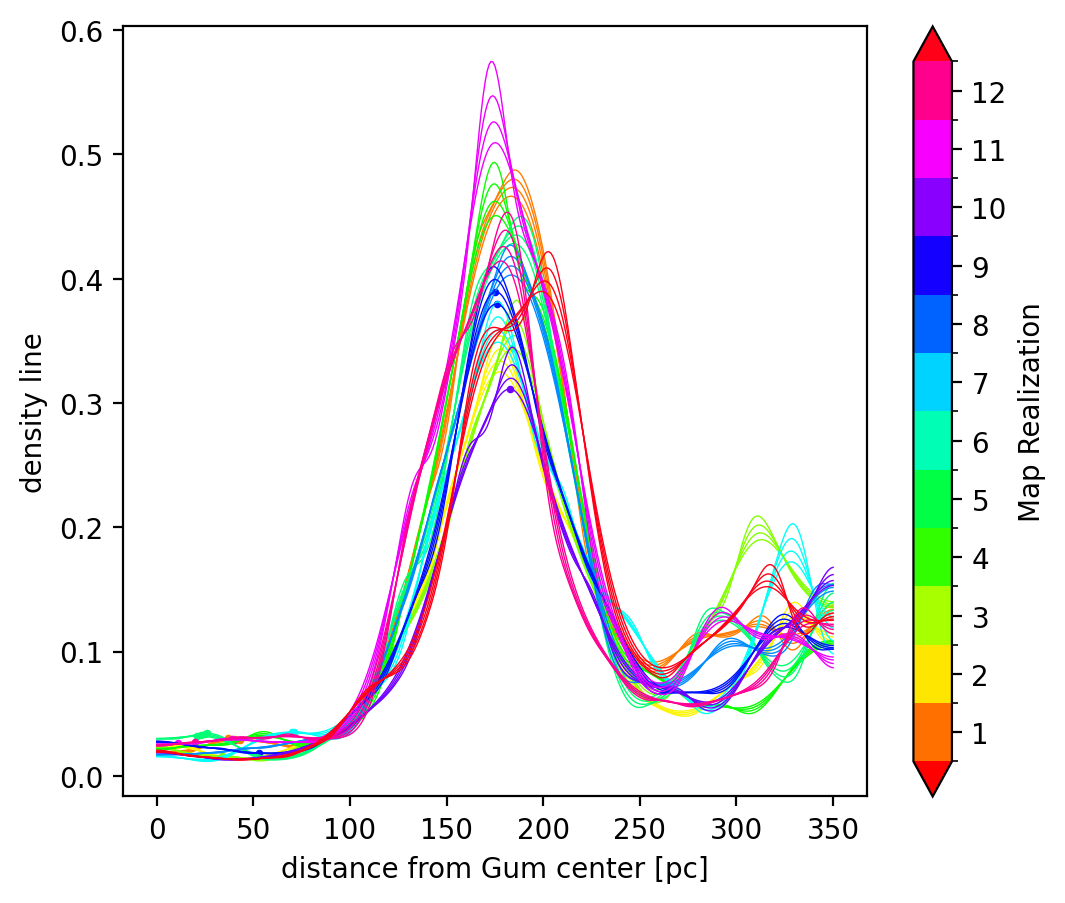

In [616]:
# plt.rcParams['lines.linewidth'] = 0.4
# plt.rcParams["axes.prop_cycle"] = \
#     plt.cycler("color", plt.cm.plasma(np.linspace(0,1,12)))

# different map, different color
%config InlineBackend.figure_format='retina'

cmap = plt.cm.hsv
# cmap = plt.cm.plasma
fig, ax = plt.subplots(figsize=(6, 5))
lw=0.5
s = 3
for i in range(1,13):
#     if i==0:
    ax.plot(gaussian_filter1d(density_line[i-1], 7.5), color=cmap(i/12), lw=lw)
    ax.plot(gaussian_filter1d(density_line[i-1], 9), color=cmap(i/12), lw=lw)
    ax.plot(gaussian_filter1d(density_line[i-1], 10.5), color=cmap(i/12), lw=lw)
    ax.plot(gaussian_filter1d(density_line[i-1], 12), color=cmap(i/12), lw=lw)
    
    if not np.isnan(peaks_all[p, i-1, 0]):
        ax.scatter(peaks_all[p, i-1, 0], gaussian_filter1d(density_line[i-1], 7.5)[int(peaks_all[p, i-1, 0])],color=cmap(i/12), s=s)
    
    if not np.isnan(peaks_all[p, i-1, 1]):    
        ax.scatter(peaks_all[p, i-1, 1], gaussian_filter1d(density_line[i-1], 9)[int(peaks_all[p, i-1, 1])],color=cmap(i/12), s=s)
    
    if not np.isnan(peaks_all[p, i-1, 2]):    
        ax.scatter(peaks_all[p, i-1, 2],  gaussian_filter1d(density_line[i-1], 10.5)[int(peaks_all[p, i-1, 2])],color=cmap(i/12), s=s)
    
    if not np.isnan(peaks_all[p, i-1, 3]):    
        ax.scatter(peaks_all[p, i-1, 3],  gaussian_filter1d(density_line[i-1], 12)[int(peaks_all[p, i-1, 3])],color=cmap(i/12), s=s)

norm = matplotlib.colors.BoundaryNorm(np.linspace(0.5, 12.5, 13), cmap.N, extend='both')
fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax, orientation='vertical', label='Map Realization', ticks=np.linspace(1.,12.,12))
plt.xlabel('distance from Gum center [pc]')
plt.ylabel('density line')
plt.show()